# **Introduction to Deep Computer Vision**

In [ ]:
# Mount files in google drive


# <font style="color:black">**Create your CNNs model** </font>
#Convolution -> ReLU -> Pooling -> Flatten -> Dense -> Output ->


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
print(f"PyTorch version: {torch.__version__}")
print(f"Is CUDA available? : {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Running on CPU")

PyTorch version: 2.6.0+cu124
Is CUDA available? : True
Current GPU: NVIDIA GeForce RTX 3050 Laptop GPU


# **Image Classification using PyTorch**


In [9]:
# -----------------------------------------------------
# CNN Image Classification (Flower Dataset - 5 Classes)
# Folder-based dataset
# -----------------------------------------------------
# --------------------------
# 1. Prepare Dataset
# --------------------------

# Define image size  to 64 pixels
IMAGE_SIZE = 64

# Applying transforms.Compose to convert input images to Tensor
transform = transforms.Compose([
    transforms.Resize([IMAGE_SIZE,IMAGE_SIZE]),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5,0.5,0.5),
        std=(0.5,0.5,0.5),
    )
])

# Load the dataset from training folder

train_data = datasets.ImageFolder(
    root = r"C:\Users\jinny\Desktop\cv\flower dataset\train",
    transform = transform 
)
# Create a DataLoader object for batching, shuffling data
train_loader = DataLoader(train_data, batch_size=8, shuffle = True)

# Get number of classes and class name
num_classes = len(train_data.classes)
class_name = train_data.classes
# --------------------------
# 2. Define CNN Model
# --------------------------
class FlowerCNN(nn.Module):
    def __init__(self, num_classes):
        super(FlowerCNN, self).__init__()
        self.features = nn.Sequential(
            # First Convolutional block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            # 32x64x64
            # Second Convolutional block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            # 64x32x32
            # Third Convolutional block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            # 128x16x16
        )

        # Compute output size
        output_cnn = int(IMAGE_SIZE/(2*2*2))
        # 8
        print(output_cnn)

        # Define fully connected layer
        self.classifier = nn.Sequential(
            # Flatten
            nn.Flatten(),
            # Dense
            nn.Linear(128 * output_cnn * output_cnn, 256),
            # ReLu
            nn.ReLU(),
            # Output
            nn.Linear(256, num_classes)
        )

    # Forward pass
    def forward(self, x):
       x = self.features(x)
       x = self.classifier(x)
       return x


# --------------------------
# 3. Device, Loss, Optimizer
# --------------------------
# Indicator of the calculating device
device = torch.device("cuda" 
                      if torch.cuda.is_available() 
                      else "cpu"
                      )

# Initialize the CNN model and move it to selected device (cpu or gpu)
model = FlowerCNN(num_classes=num_classes).to(device)

# CrossEntorpyLoss combines LogSoftmax and Negative Log-likelihood loss
criterion = nn.CrossEntropyLoss()
#  Define the optimizeer (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --------------------------
# 4. Train Model
# --------------------------
# Number of training epochs
epochs = 10

# Training loop
for epoch in range(epochs):
    # Set the model to training mode
    model.train()

    # Initialize variables calculate loss and accuracy
    running_loss = 0.0
    correct = 0
    total = 0

    # Interate over batchs of training data
    for images, lables in train_loader:

        # Move input data and labels to the selected device
        images = images.to(device)
        lables = lables.to(device)

        # Clear the gradients from the previous step
        optimizer.zero_grad()
        # Forword pass compute model  prediction
        output = model(images)
        # Compute the loss between prediction and true labels
        loss = criterion(output, lables)
        # Backward pass: compute gradients
        loss.backward()
        # Updata modelparameters using optimizer
        optimizer.step()

        # Accumulate the training loss
        running_loss += loss.item()
        # Get predicted class labels
        _, predicted = torch.max(output, 1)
        # Update total number of samples    
        total += lables.size(0)
        # Count correctly predicted sample
        correct += (predicted == lables).sum().item()

     # Calculate training accuracy for the epoch
    train_acc = 100*correct/total

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Loss: {running_loss/len(train_loader):.4f} "
          f"Train Acc: {train_acc:.2f}%")




8
Epoch [1/10] Loss: 1.3763 Train Acc: 41.19%
Epoch [2/10] Loss: 1.1436 Train Acc: 52.56%
Epoch [3/10] Loss: 1.0210 Train Acc: 61.89%
Epoch [4/10] Loss: 0.8319 Train Acc: 68.55%
Epoch [5/10] Loss: 0.7031 Train Acc: 73.46%
Epoch [6/10] Loss: 0.5672 Train Acc: 77.46%
Epoch [7/10] Loss: 0.3905 Train Acc: 85.55%
Epoch [8/10] Loss: 0.2224 Train Acc: 91.50%
Epoch [9/10] Loss: 0.2052 Train Acc: 92.73%
Epoch [10/10] Loss: 0.1067 Train Acc: 96.82%


# **Classify unseen image**

predicted: daisy


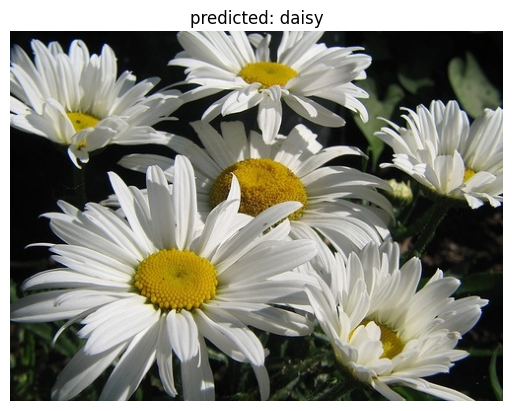

In [ ]:
# --------------------------
# 5. Test Model
# --------------------------

def preprocess_image(img_path, transform, device):
    # Load the image from path and convert it to RGB format
    img = Image.open(img_path).convert("RGB")
    
    # Keep a copy of the original image for visualization
    raw_img = img.copy()

    # Apply the same transformations used during training
    img = transform(img)

    # Add a batch dimention [1, c, h, w ]
    img = img.unsqueeze(0)
    # Move the image tensor to the selected device (CPU or GPU)
    img = img.to(device)

    # Return preprocessing imag and original image
    return img, raw_img

def display(image, class_name):
    # Display the image with the predicted calss label
    plt.imshow(image)
    plt.title(f"predicted: {class_name}")
    plt.axis("off")
    plt.show()
# Path to the test image
img_path = r"C:\Users\jinny\Desktop\cv\flower dataset\test\Image_50.jpg"
# Preprocess the image and get both the input tensor and the raw image
test_loader, raw_img = preprocess_image(
    img_path,
    transform,
    device
)
# Set the model to evaluation mode
model.eval()

# Disable gradient calculation for inference
with torch.no_grad():
    # Forward pass: get model predictions
    output = model(test_loader)
    # Get the index of the class with the highest score
    _, predicted = torch.max(output, 1)
    # Print the predicted class name
    print(f"predicted: {class_name[predicted[0]]}")
    # Display the image along with its predicted class
    display(raw_img,
            class_name[predicted[0]]
            )
